In [13]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

rcParams['figure.figsize'] = 14,8

In [2]:
sys.path.append('../lib')
from agent import Agent
from market import Market
from model.conv import Conv
%load_ext autoreload
%autoreload 2

c:\users\user\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### BTC_USDデータの読み込み

In [3]:
pdf_btcusd = pd.read_csv('../data/bitmex/BTCUSD/chart_1hour.csv')

In [4]:
pdf_btcusd.head()

len(pdf_btcusd)

pdf_btcusd['index'] = pd.to_datetime(pdf_btcusd['index'])

# 日時でソート
pdf_btcusd = pdf_btcusd.sort_values('index')
pdf_btcusd = pdf_btcusd.reset_index(drop=True)

pdf_btcusd.head()

N_EPISODES = 10
STATE_WINDOW = 30
TIMESERIES_DATA_NUM = 1  # 時系列データの数。今回は終値のみ
N_ACTIONS = 4  # ノーポジ時(仮想通貨保有していない)：ノーポジ継続/買い。非ノーポジ(仮想通貨保有)時：売り、保持
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
DISCOUNT_FACTOR = 0.8
COST = 0.

### 学習済みモデルでシミュレーション

#### 学習済みモデルの読み込み

In [5]:
pretrained_model = Conv(state_shape=(STATE_WINDOW, TIMESERIES_DATA_NUM), n_actions=N_ACTIONS)

In [6]:
pretrained_model.load(
    fld='../output/model/conv',
    learning_rate=LEARNING_RATE
)

#### エージェント初期化

In [7]:
agent = Agent(pretrained_model, discount_factor=DISCOUNT_FACTOR, batch_size=BATCH_SIZE)

#### マーケット初期化

In [8]:
market = Market(
    prices=np.array(pdf_btcusd['close']).reshape(pdf_btcusd['close'].shape[0], 1), 
    window=STATE_WINDOW, 
    model=pretrained_model, 
    cost=COST
)

#### シミュレーションをN_EPISODE回行う（学習はしない）

In [9]:
%%time
actions_hist = []
cum_rewards_hist = []
assets_hist = []

for episode in range(10):
    
    t_idx = STATE_WINDOW
    
    cum_rewards = []
    prev_cum_rewards = 0.
    actions = []
    states = []
    assets = []
    done = False
    
    state, valid_actions = market.reset()
    print('episode : ', episode)
    #print('state : ', state)
    #print('valid_actions : ', valid_actions)
    
    while not done:
        if t_idx % 1000 == 0:
            print('t_idx : ', t_idx)
        
        # 現在の状態と有効アクションリストから次にとるアクションを取得
        action = agent.act(state, valid_actions)
        #print('action : ', action)
        # アクションを実行し次の状態へ
        next_state, reward, done, valid_actions, asset = market.step(action)
        
        cum_rewards.append(prev_cum_rewards+reward)
        prev_cum_rewards = cum_rewards[-1]
        actions.append(action)
        states.append(next_state)
        assets.append(asset)
        
#         # 状態の保存と学習
#         agent.remember(state, action, reward, next_state, done, valid_actions)
#         agent.replay()
        
        state = next_state
        
        t_idx += 1
        
    actions_hist.append(actions)
    cum_rewards_hist.append(cum_rewards)
    assets_hist.append(assets)

episode :  0
t_idx :  1000
t_idx :  2000
t_idx :  3000
t_idx :  4000
t_idx :  5000
t_idx :  6000
t_idx :  7000
t_idx :  8000
t_idx :  9000
t_idx :  10000
t_idx :  11000
t_idx :  12000
t_idx :  13000
t_idx :  14000
episode :  1
t_idx :  1000
t_idx :  2000
t_idx :  3000
t_idx :  4000
t_idx :  5000
t_idx :  6000
t_idx :  7000
t_idx :  8000
t_idx :  9000
t_idx :  10000
t_idx :  11000
t_idx :  12000
t_idx :  13000
t_idx :  14000
episode :  2
t_idx :  1000
t_idx :  2000
t_idx :  3000
t_idx :  4000
t_idx :  5000
t_idx :  6000
t_idx :  7000
t_idx :  8000
t_idx :  9000
t_idx :  10000
t_idx :  11000
t_idx :  12000
t_idx :  13000
t_idx :  14000
episode :  3
t_idx :  1000
t_idx :  2000
t_idx :  3000
t_idx :  4000
t_idx :  5000
t_idx :  6000
t_idx :  7000
t_idx :  8000
t_idx :  9000
t_idx :  10000
t_idx :  11000
t_idx :  12000
t_idx :  13000
t_idx :  14000
episode :  4
t_idx :  1000
t_idx :  2000
t_idx :  3000
t_idx :  4000
t_idx :  5000
t_idx :  6000
t_idx :  7000
t_idx :  8000
t_idx :  9000
t_idx

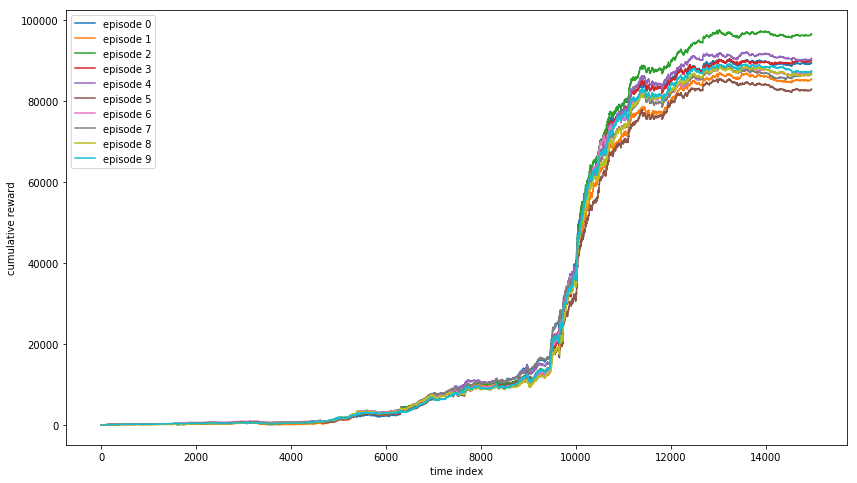

In [14]:
# 総報酬の推移
plt.clf()
for i in range(len(cum_rewards_hist)):
    plt.plot(cum_rewards_hist[i], label='episode {}'.format(i))

plt.xlabel('time index')
plt.ylabel('cumulative reward')
plt.legend()
plt.show()

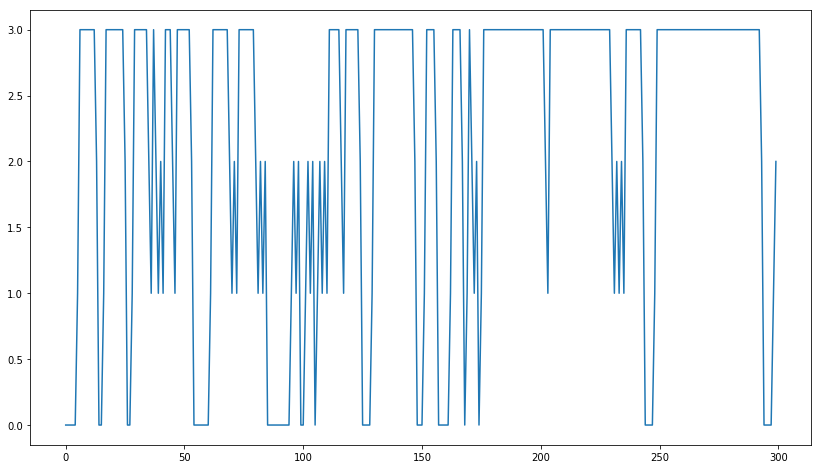

In [15]:
# アクションの遷移
plt.clf()
plt.plot(actions_hist[-1][:300])

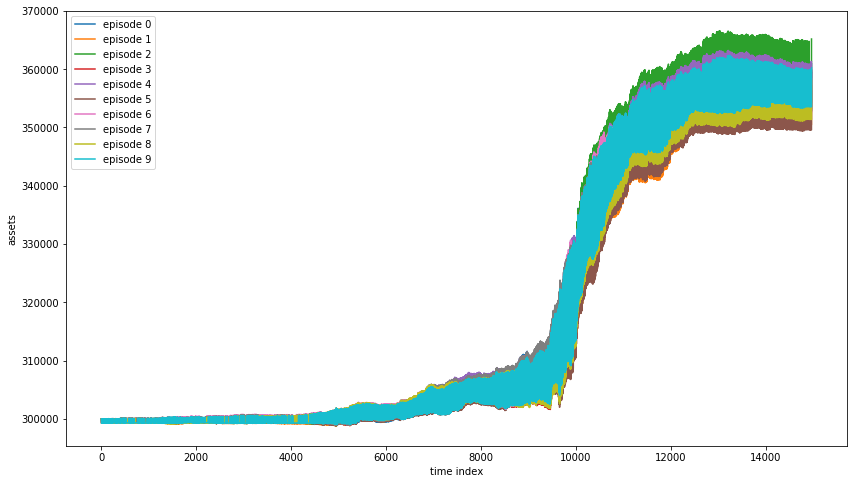

In [16]:
# 総資産の推移
plt.clf()
for i in range(len(assets_hist)):
    plt.plot(assets_hist[i], label='episode {}'.format(i))

plt.xlabel('time index')
plt.ylabel('assets')
plt.legend()
plt.show()